In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wget
import warnings
warnings.filterwarnings('ignore')

In [2]:
# getting dataset

wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

'housing.csv'

In [3]:
# loading dataset

data = pd.read_csv('housing.csv')
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data Preparation

In [4]:
cols_used = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]

data = data[cols_used]

data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
data.shape

(20640, 10)

In [6]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

* There are 20640 records and 10 features in the dataset

* There are 207 null values in the total_bedrooms column

    * Next, I will null values with 0

In [7]:
data.fillna(0,inplace=True)

data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

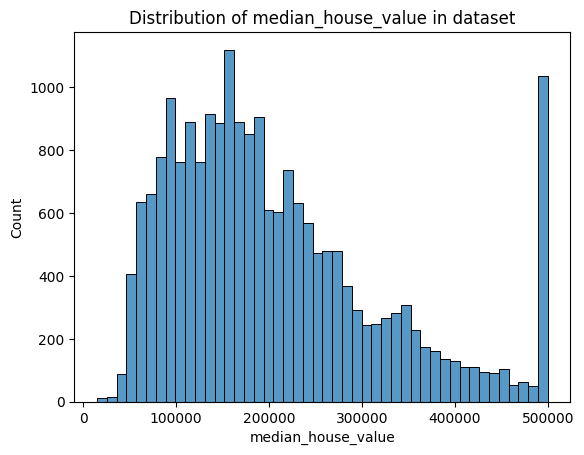

In [9]:
target = 'median_house_value'


sns.histplot(data, x = target)
plt.title(f'Distribution of {target} in dataset');

* There is a presence of long tail in the target variable

    * I will be log transforming that variable to try to reduce its skewness

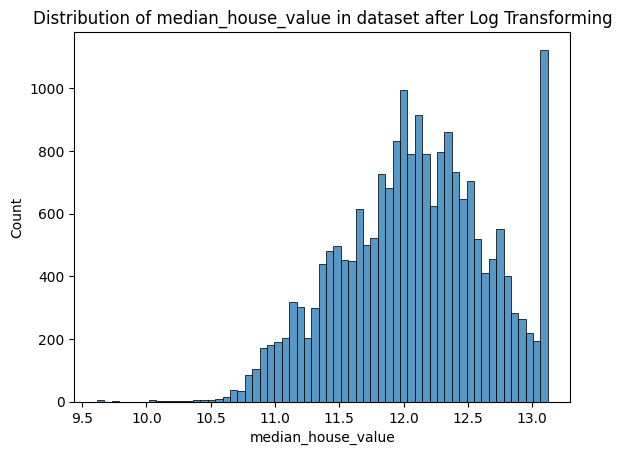

In [10]:
data[target] = np.log1p(data[target])

sns.histplot(data, x = target)
plt.title(f'Distribution of {target} in dataset after Log Transforming');

## Splitting Dataset

In [11]:
X = data.drop(columns=[target])

y = data[target]

In [12]:
from sklearn.model_selection import train_test_split

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size = 0.25, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((12384, 9), (4128, 9), (4128, 9))

### Using DictVectorizer to turn our data into matrices

In [13]:
dict_train = X_train.to_dict(orient='records')
dict_val = X_val.to_dict(orient='records')

In [14]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

X_train_enc = dv.fit_transform(dict_train)
X_val_enc = dv.fit_transform(dict_val)



# Question 1

* Let's train a decision tree regressor to predict the median_house_value variable.

    * Train a model with `max_depth=1`

In [15]:
from sklearn.tree import DecisionTreeRegressor, export_text

model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(X_train_enc,y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
print(export_text(model_dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



* Which feature is used for splitting the data?

    * Answer: **ocean_proximity=INLAND**

# Question 2

* Train a random forest model with these parameters:

    * n_estimators=10
    * random_state=1
    * n_jobs=-1 (optional - to make training faster)

In [17]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(X_train_enc, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
from sklearn.metrics import mean_squared_error

y_pred = model_rf.predict(X_val_enc)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))

round(rmse, 2)

0.25

* What's the RMSE of this model on validation?

    * Answer: **0.25**

# Question 3

* Now let's experiment with the n_estimators parameter

    * Try different values of this parameter from 10 to 200 with step 10.
    * Set random_state to 1.
    * Evaluate the model on the validation dataset.

In [19]:
from tqdm import tqdm

scores = []
for estimator in tqdm(range(10,201,10)):

    model_rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs = -1)
    model_rf.fit(X_train_enc, y_train)

    y_pred = model_rf.predict(X_val_enc)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((estimator, rmse))
    print('%3s : %.3f'%(estimator,rmse))

  5%|▌         | 1/20 [00:00<00:13,  1.42it/s]

 10 : 0.246


 10%|█         | 2/20 [00:01<00:17,  1.04it/s]

 20 : 0.239


 15%|█▌        | 3/20 [00:03<00:21,  1.27s/it]

 30 : 0.236


 20%|██        | 4/20 [00:05<00:27,  1.72s/it]

 40 : 0.235


 25%|██▌       | 5/20 [00:08<00:31,  2.09s/it]

 50 : 0.233


 30%|███       | 6/20 [00:12<00:38,  2.76s/it]

 60 : 0.233


 35%|███▌      | 7/20 [00:19<00:54,  4.20s/it]

 70 : 0.232


 40%|████      | 8/20 [00:28<01:08,  5.67s/it]

 80 : 0.233


 45%|████▌     | 9/20 [00:34<01:02,  5.69s/it]

 90 : 0.232


 50%|█████     | 10/20 [00:41<01:00,  6.07s/it]

100 : 0.232


 55%|█████▌    | 11/20 [00:49<00:59,  6.61s/it]

110 : 0.232


 60%|██████    | 12/20 [00:59<01:02,  7.82s/it]

120 : 0.232


 65%|██████▌   | 13/20 [01:07<00:54,  7.77s/it]

130 : 0.232


 70%|███████   | 14/20 [01:15<00:46,  7.80s/it]

140 : 0.232


 75%|███████▌  | 15/20 [01:23<00:40,  8.05s/it]

150 : 0.232


 80%|████████  | 16/20 [01:33<00:33,  8.46s/it]

160 : 0.232


 85%|████████▌ | 17/20 [01:42<00:26,  8.72s/it]

170 : 0.232


 90%|█████████ | 18/20 [01:52<00:18,  9.03s/it]

180 : 0.232


 95%|█████████▌| 19/20 [02:02<00:09,  9.48s/it]

190 : 0.232


100%|██████████| 20/20 [02:14<00:00,  6.75s/it]

200 : 0.232


In [20]:
df_scores = pd.DataFrame(scores, columns = ['n_estimators', 'rmse'])

df_scores.sort_values(by='rmse',ascending=False)


,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104
5,60,0.232843
7,80,0.232527
6,70,0.232384
8,90,0.232215
9,100,0.231968


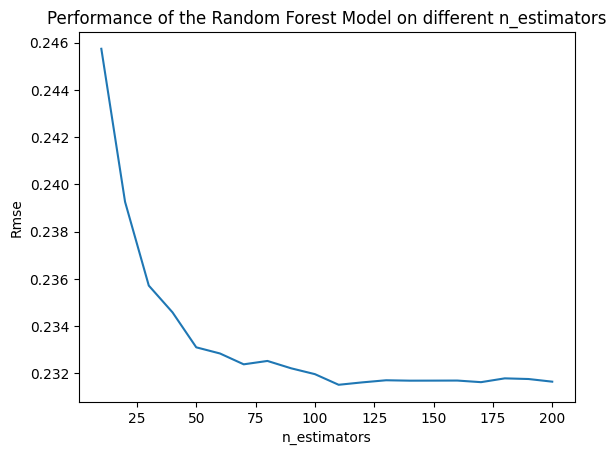

In [21]:
plt.plot(df_scores['n_estimators'], df_scores['rmse'])
plt.title('Performance of the Random Forest Model on different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Rmse');

* After which value of n_estimators does RMSE stop improving?

    * Answer: **150**

# Question 4

* Let's select the best max_depth:

    * Try different values of max_depth: [10, 15, 20, 25]
    * For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
    * Fix the random seed: random_state=1

In [22]:


scores = []
for depth in [10,15,20,25]:
    for estimator in tqdm(range(10,201,10)):

        model_rf = RandomForestRegressor(max_depth=depth, n_estimators=estimator, random_state=1, n_jobs = -1)
        model_rf.fit(X_train_enc, y_train)

        y_pred = model_rf.predict(X_val_enc)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((depth,estimator, rmse))
        

100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


In [23]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'n_estimators', 'rmse'])

df_scores.sort_values(by='rmse',ascending=False)

,max_depth,n_estimators,rmse
0,10,10,0.255042
1,10,20,0.252784
2,10,30,0.251647
3,10,40,0.251062
4,10,50,0.250192
...,...,...,...
75,25,160,0.231484
73,25,140,0.231458
76,25,170,0.231440
71,25,120,0.231297


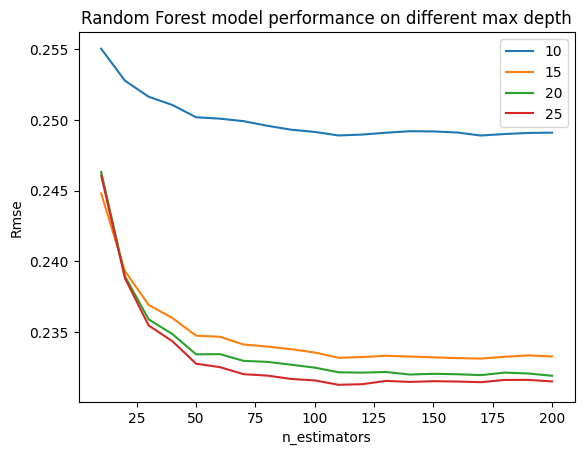

In [24]:
for depth in [10, 15, 20, 25]:
    df_plot = df_scores[df_scores.max_depth == depth]
    plt.plot(df_plot.n_estimators, df_plot.rmse, label=depth)

plt.legend()
plt.title('Random Forest model performance on different max depth')
plt.xlabel('n_estimators')
plt.ylabel('Rmse');

* What's the best max_depth?

    * Answer: **25**

# Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

* Train the model with these parametes:

    * n_estimators=10,
    * max_depth=20,
    * random_state=1,
    * n_jobs=-1 (optional)

In [25]:
model_rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)

model_rf.fit(X_train_enc, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [26]:
pd.DataFrame(model_rf.feature_importances_, dv.get_feature_names_out(),columns=['Importance']).sort_values(by='Importance',ascending=False)

,Importance
median_income,0.362913
ocean_proximity=INLAND,0.310901
latitude,0.101334
longitude,0.096265
housing_median_age,0.033094
population,0.030918
total_rooms,0.020536
total_bedrooms,0.019041
households,0.016957
ocean_proximity=NEAR OCEAN,0.004228


* What's the most important feature?

    * Answer: **median_income**

# Question 6

* Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

    * Install XGBoost
    * Create DMatrix for train and validation
    * Create a watchlist
    * Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [27]:
# getting feature names from dictvectorizer
features = []
for x in dv.get_feature_names():
    x=x.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    features.append(x)

In [28]:
import xgboost as xgb

# cxreating a Dmatrix for train and val sets
dtrain = xgb.DMatrix(X_train_enc, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_enc, label=y_val, feature_names=features)

In [29]:
#creating a watchlist 

watchlist = [(dtrain,'train'), (dval,'val')]

In [30]:
%%capture output_1

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# training an xgboost model with eta = 0.3
model_xgb = xgb.train(xgb_params,dtrain=dtrain, evals=watchlist, verbose_eval = 5,num_boost_round=100)

In [31]:
print((output_1).stdout)

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610



In [32]:
%%capture output_2

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

# training an xgboost model with eta = 0.3
model_xgb = xgb.train(xgb_params,dtrain=dtrain, evals=watchlist, verbose_eval = 5,num_boost_round=100)

In [33]:
# defining a function that parses the output from the xgb model

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [34]:
scores = {}

scores['eta=0.3'] = parse_xgb_output(output_1)
scores['eta=0.1'] = parse_xgb_output(output_2)



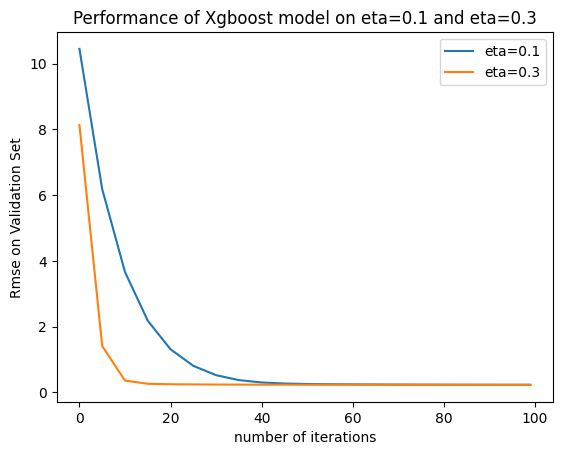

In [35]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_rmse,
        label='eta=0.1')

plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_rmse,
        label='eta=0.3')
plt.legend() 
plt.title('Performance of Xgboost model on eta=0.1 and eta=0.3')
plt.xlabel('number of iterations')
plt.ylabel('Rmse on Validation Set');


* Which eta leads to the best RMSE score on the validation dataset?

    * Answer: **0.3**